In [20]:
from dotenv import load_dotenv
from pathlib import Path
import os
import mysql.connector
import pandas as pd

env_path = "/Users/rang/Desktop/PJ/PY/env.env"
load_dotenv(dotenv_path=env_path)

def get_connection():
    conn = mysql.connector.connect(
        host=os.getenv("db_host"),
        database=os.getenv("db_database"),
        user=os.getenv("db_username"),
        password=os.getenv("db_password")
    )
    return conn

def is_invalid(value):
    return pd.isna(value) or value == ""

# ####################################### #
# get_file_lst
# 파일 경로와 목록 정보를 조회
# ####################################### #
def get_file_lst(assess_type, question_cd, question_no=None, order_num=None):
    conn = None
    cursor = None
    try:
        conn = get_connection()
        cursor = conn.cursor()

        sql = ""
        sql +=  "select lst.ORDER_NUM, lst.ASSESS_TYPE, lst.QUESTION_CD, lst.QUESTION_NO, lst.QUESTION_MINOR_NO "
        sql +=  "   , concat(lst.MAIN_PATH,'/',lst.SUB_PATH) as PATH, lst.FILE_NAME, lst.DURATION, lst.RATE "
        sql +=  "   , ref.SCORE, alc.SCORE_ALLOCATION as alc_score, alc.note "
        sql +=  "from assess_file_lst lst "
        sql +=  "   inner join assess_lst alst "
        sql +=  "      on lst.PATIENT_ID = alst.PATIENT_ID "
        sql +=  "      and lst.ORDER_NUM = alst.ORDER_NUM "
        sql +=  "      and alst.EXCLUDED = '0' "
        sql +=  "   inner join assess_score_reference ref "
        sql +=  "      on lst.PATIENT_ID = ref.PATIENT_ID "
        sql +=  "      and lst.ORDER_NUM = ref.ORDER_NUM "
        sql +=  "      and lst.ASSESS_TYPE = ref.ASSESS_TYPE "
        sql +=  "      and lst.QUESTION_CD = ref.QUESTION_CD "
        sql +=  "      and lst.QUESTION_NO = ref.QUESTION_NO "
        sql +=  "       and ref.USE_YN = 'Y' "
        sql +=  "   left outer join assess_score_allocation alc "
        sql +=  "      on lst.ASSESS_TYPE = alc.ASSESS_TYPE "
        sql +=  "      and lst.QUESTION_CD = alc.QUESTION_CD "
        sql +=  "      and lst.QUESTION_NO = alc.QUESTION_NO "
        sql += f"where lst.ASSESS_TYPE = '{assess_type}' "
        sql += f"and lst.QUESTION_CD = '{question_cd}' "
        if question_no:
            sql += f"and lst.QUESTION_NO = {question_no} "
        if order_num:
            sql += f"and lst.ORDER_NUM = {order_num} "
        sql +=  "and lst.USE_YN = 'Y' "
    
        cursor.execute(sql)
        rows = cursor.fetchall()
        ret_df = pd.DataFrame(rows, columns=['ORDER_NUM', 'ASSESS_TYPE', 'QUESTION_CD', 'QUESTION_NO', 'QUESTION_MINOR_NO', 'Path','File Name','Duration', 'Rate', 'Score(Refer)', 'Score(Alloc)', 'Note' ])

        msg = f'{len(ret_df)}건의 데이터가 조회되었습니다.'
        return msg, ret_df

    except Exception as e:
        return f"오류 발생: {str(e)}", None

    finally:
        if cursor:
            cursor.close()
        if conn:
            conn.close()

In [21]:
_, temp = get_file_lst("CLAP_A", "GUESS_END")
clapdata = temp[["QUESTION_NO","Path", "File Name", "Score(Refer)"]]
clapdata["Patient_ID"] = clapdata["Path"].str.split("/").str[0]
clapdata

/var/folders/72/bfx4dl3x59z_2lk5805zqw900000gn/T/ipykernel_37573/1405830055.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clapdata["Patient_ID"] = clapdata["Path"].str.split("/").str[0]


,QUESTION_NO,Path,File Name,Score(Refer),Patient_ID
0,1,1001/clap_a/4,p_1_0.wav,1.0,1001
1,2,1001/clap_a/4,p_2_0.wav,2.0,1001
2,3,1001/clap_a/4,p_3_0.wav,2.0,1001
3,4,1001/clap_a/4,p_4_0.wav,2.0,1001
4,5,1001/clap_a/4,p_5_0.wav,2.0,1001
...,...,...,...,...,...
295,1,5067/clap_a/4,p_1_0.wav,2.0,5067
296,2,5067/clap_a/4,p_2_0.wav,2.0,5067
297,3,5067/clap_a/4,p_3_0.wav,2.0,5067
298,4,5067/clap_a/4,p_4_0.wav,2.0,5067


In [22]:
patients = clapdata["Patient_ID"].unique()
patients

array(['1001', '1003', '1004', '1015', '1023', '1024', '1025', '1026',
       '1027', '1032', '1033', '1034', '1035', '1036', '1042', '1043',
       '1045', '2006', '2007', '2014', '3008', '3009', '3010', '3011',
       '3017', '3018', '3019', '3020', '3022', '3028', '3029', '3030',
       '3037', '3038', '3039', '3040', '3041', '3070', '3071', '3074',
       '3075', '3076', '4046', '4047', '4052', '4053', '4054', '4055',
       '4056', '4057', '5058', '5059', '5060', '5061', '5062', '5063',
       '5064', '5065', '5066', '5067'], dtype=object)

In [23]:
wav_paths, prompt_ids, scores = [], [], []
base_dir = "/Users/rang/Documents/Clapdata"

for patient_id in patients:
    row = clapdata[clapdata["Patient_ID"] == patient_id]
    for prompt_id in range(5):  # 문항 수: 1 ~ 5
        wav1 = os.path.join(base_dir, str(patient_id), "CLAP_A", "4", f"p_{prompt_id+1}_1.wav")
        wav0 = os.path.join(base_dir, str(patient_id), "CLAP_A", "4", f"p_{prompt_id+1}_0.wav")
        if os.path.exists(wav1):
            wav_paths.append(wav1)
        elif os.path.exists(wav0):
            wav_paths.append(wav0)

        prompt_ids.append(prompt_id)

        score = clapdata.loc[(clapdata.Patient_ID==patient_id) & 
                     (clapdata.QUESTION_NO==(prompt_id+1)),
                     'Score(Refer)'].iloc[0]

        scores.append(int(score))

In [24]:
# =========================
# Imports & Reproducibility
# =========================
import os, random
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch

# 재현성 고정
SEED = 42
tf.random.set_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# =========================
# Config
# =========================
SAMPLE_RATE = 16000
N_MELS = 128
TEMPERATURE = 0
LSTM_UNITS = 128
DROPOUT = 0.3
MAX_TOKEN_LENGTH = 256
TOKEN_EMBED_DIM = 256
PROMPT_EMBED_DIM = 16
LR = 1e-4
EPOCHS = 100
BATCH_SIZE = 16                 # 총 데이터 300개 / 학습 데이터 210개
NUM_PROMPTS = 5 

# =========================
# Whisper load (KO)
# =========================
device = torch.device("mps" if torch.backends.mps.is_available()                # macOS
                      else ("cuda" if torch.cuda.is_available() else "cpu"))    # windos
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
whisper_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to(device)
forced_ids = processor.get_decoder_prompt_ids(language="ko", task="transcribe")

# 토크나이저/패딩
_vocab_ids = list(processor.tokenizer.get_vocab().values())
BASE_VOCAB = max(_vocab_ids) + 1    # 추가 토큰까지 포함한 전체 vocab의 "최대 토큰ID + 1"
PAD_ID = BASE_VOCAB                 # 패딩용 새 토큰 ID

# =========================
# Feature utils
# =========================
def wav_to_mel(wav_path, sr=SAMPLE_RATE, n_mels=N_MELS):
    y, _ = librosa.load(wav_path, sr=sr, mono=True)                 # 음성 파일을 16kHz 단일 채널로 로드
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels) # Mel-Spectrogram 추출 (128개 멜 필터 사용)
    mel_db = librosa.power_to_db(mel, ref=np.max)                   # 파워 스펙트럼을 dB 스케일로 변환 (로그 변환)
    mel_db = np.expand_dims(mel_db, axis=-1)                        # 채널 차원 추가(4차원 텐서 형태 유지를 위해) # (128, T, 1) = (n_mels, T, 1)
    return mel_db

@torch.no_grad()
def wav_to_tokens_and_mask(wav_path, sr=SAMPLE_RATE):
    if not os.path.exists(wav_path):
        raise FileNotFoundError(f"WAV not found: {wav_path}")
    y, _ = librosa.load(wav_path, sr=sr, mono=True)
    inputs = processor(y, sampling_rate=sr, return_tensors="pt")
    input_features = inputs.input_features.to(device)
    pred_ids = whisper_model.generate(
        input_features,
        forced_decoder_ids=forced_ids,
        do_sample=False,
        max_new_tokens=MAX_TOKEN_LENGTH,
    )
    token_ids = pred_ids[0].cpu().numpy().astype(np.int32)
    token_len = token_ids.shape[0]
    if token_len < MAX_TOKEN_LENGTH:                        # 토큰 길이가 설정한 최대 토큰 길이보다 짧은 경우,
        pad_len = MAX_TOKEN_LENGTH - token_len              # 부족한 길이만큼 패딩할 길이로 설정
        token_mask = np.concatenate(
            [np.ones(token_len, np.int32), np.zeros(pad_len, np.int32)], axis=0)    # 토큰 마스크 = 토큰 위치 1로, 패딩 위치 0으로 채우고 concat
        token_ids = np.concatenate([token_ids, np.full(pad_len, PAD_ID, np.int32)], axis=0)                 # np.full(shape, fill_value, dtype) 
                                                                                                            # '토큰 id'와 '패딩 길이만큼 PAD_ID(패딩용 토큰 ID)로 채운 것'을 concat
    else:
        token_ids = token_ids[:MAX_TOKEN_LENGTH]            # 토큰 길이가 설정한 최대 토큰 길이보다 긴 경우 잘라내기
        token_mask = np.ones(MAX_TOKEN_LENGTH, np.int32)    # 토큰 마스크 = 토큰 길이(=최대 토큰 길이)만큼 1로 채운 것

    if token_mask.sum() == 0:                               # 안전장치: 전부 패딩인 경우를 방지
        token_mask[0] = 1

    return token_ids, token_mask                            # token_ids: 길이 MAX_TOKEN_LENGTH의 정수 배열 # token_mask: 같은 길이의 0/1 배열

def pad_mels(mel_list):
    max_time = max(m.shape[1] for m in mel_list)            # mel_list: 서로 다른 길이의 멜스펙토그램을 모아둔 리스트 > 패딩하기 위한 함수 # (B,128,T,1)로 패딩 스택
    batch = np.zeros((len(mel_list), N_MELS, max_time, 1), dtype=np.float32)
    for i, mel in enumerate(mel_list):
        batch[i, :, :mel.shape[1], :] = mel
    return batch                                            # (B, 128, max_t, 1) # B = len(mel_list)                         

# =========================
# 데이터: 음성 파일, 문항 번호, 점수(라벨) 리스트
# =========================
wav_paths, prompt_ids, scores = [], [], []

base_dir = "/Users/rang/Documents/Clapdata"
for patient_id in patients:
    row = clapdata[clapdata["Patient_ID"] == patient_id]
    for prompt_id in range(5):  # 문항 수: 1 ~ 5
        wav1 = os.path.join(base_dir, str(patient_id), "CLAP_A", "4", f"p_{prompt_id+1}_1.wav")
        wav0 = os.path.join(base_dir, str(patient_id), "CLAP_A", "4", f"p_{prompt_id+1}_0.wav")
        if os.path.exists(wav1):
            wav_paths.append(wav1)
        elif os.path.exists(wav0):
            wav_paths.append(wav0)

        prompt_ids.append(prompt_id)

        score = clapdata.loc[(clapdata.Patient_ID==patient_id) & 
                     (clapdata.QUESTION_NO==(prompt_id+1)),
                     'Score(Refer)'].iloc[0]

        scores.append(int(score))

assert len(wav_paths) == len(prompt_ids) == len(scores), f"리스트 길이 불일치: {len(wav_paths)}, {len(prompt_ids)}, {len(scores)}"

NUM_SAMPLES = len(wav_paths)
print(f"[INFO] 데이터 수 = {NUM_SAMPLES}")                  # 300개 (환자 60명 * 5문항씩) 데이터 다 들어왔는지 확인

# ========================
# 문항별 정답 후보 사전
PROMPT_ANSWERS = {
    0: {"덥다", "뜨겁다", "뜨거워", "곱다", "따뜻하다", "섭다"},
    1: {"작다", "조그맣다", "짝다", "쪼그마해요", "작습(니다)", "적다"},
    2: {"곱다", "오는 말이 곱다", "돕다", "봅다", "겁다", "좋다", "홉다"},
    3: {"달다", "달달하다", "달라", "달음니다"},
    4: {"지운다", "지우다", "지워", "지웠다", "지우다딴다"}
}

# 안전 체크: 문항 수와 일치해야 함
assert len(PROMPT_ANSWERS) == NUM_PROMPTS, f"PROMPT_ANSWERS 문항 수({len(PROMPT_ANSWERS)}) != NUM_PROMPTS({NUM_PROMPTS})"

# 전역 어휘/가중치/마스크 생성
all_words = sorted({word for ws_set in PROMPT_ANSWERS.values() for word in ws_set})     # 모든 정답 후보 가져오기
WORD2IDX = {w:i for i,w in enumerate(all_words)}                                        # 각 후보에 index 매기기                                  
NUM_LABELS = len(all_words)

# 문항별 후보 마스크(PxM)(= NUM_PROMPTS X NUM_LABELS)
PROMPT_MASKS = np.zeros((NUM_PROMPTS, NUM_LABELS), dtype=np.float32)
for prompt_id in range(NUM_PROMPTS):
    for word in PROMPT_ANSWERS[prompt_id]:
        PROMPT_MASKS[prompt_id, WORD2IDX[word]] = 1                                     # 문항별 정답 후보만 1, 나머지는 0으로 채운 마스크

# =========================
# Dataset tensors
# =========================
mel_list, tok_list, msk_list, prompt_list = [], [], [], []

for wav, prompt_id in zip(wav_paths, prompt_ids):
    mel = wav_to_mel(wav)
    tok_ids, tok_msk = wav_to_tokens_and_mask(wav)

    mel_list.append(mel)
    tok_list.append(tok_ids)
    msk_list.append(tok_msk)
    prompt_list.append(prompt_id)

mel_data = pad_mels(mel_list)                        # (B,128,T,1)
tok_data = np.stack(tok_list, axis=0).astype(np.int32)   # (B,L)
msk_data = np.stack(msk_list, axis=0).astype(np.int32)   # (B,L)
prompt_data = np.array(prompt_list, dtype=np.int32)      # (B,)
scores = np.array(scores, dtype=np.int32)
y_oh = tf.keras.utils.to_categorical(scores)

max_seen_token = int(tok_data.max()) if tok_data.size else 0
TOK_INPUT_DIM = max(PAD_ID, max_seen_token) + 1             # 현재는 PAD_ID, max_seen_token 값이 같지만 나중을 위해서 이렇게 처리,,
print(f"[INFO] Embedding input_dim={TOK_INPUT_DIM} (pad_id={PAD_ID}, max_seen={max_seen_token})")

[INFO] 데이터 수 = 300


Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


[INFO] Embedding input_dim=51866 (pad_id=51865, max_seen=51865)


In [25]:
# =========================
# Model
# ========================= 
L = tf.keras.layers

# inputs
mel_input  = L.Input(shape=(N_MELS, None, 1), name="mel_input")
tok_input  = L.Input(shape=(MAX_TOKEN_LENGTH,), dtype='int32', name="token_input")
msk_input  = L.Input(shape=(MAX_TOKEN_LENGTH,), dtype='int32', name="token_mask")
pid_input  = L.Input(shape=(), dtype='int32', name="prompt_id")
sw_input = L.Input(shape=(NUM_LABELS,), dtype='float32', name="sw")

# mel path
x1 = L.Permute((2,1,3))(mel_input)          # (B,128,T,1) → (B,T,128,1)
x1 = L.Reshape((-1, N_MELS))(x1)            # (B,T,128) ← 값은 그대로, 채널축(=1)만 제거
x1 = L.Bidirectional(L.LSTM(LSTM_UNITS, return_sequences=True))(x1) # (B,T,256) # 정/역 128씩 concat
x1 = L.Dropout(DROPOUT)(x1)                 # (B,T,256)

# token path
x2 = L.Embedding(input_dim=TOK_INPUT_DIM, output_dim=TOKEN_EMBED_DIM)(tok_input)         # (B,L) → (B,L,256)=(B, L, TOKEN_EMBED_DIM)
x2 = L.Bidirectional(L.LSTM(LSTM_UNITS, return_sequences=True))(x2) # (B,L,256)
x2 = L.Dropout(DROPOUT)(x2)                                         # (B,L,256)

@tf.keras.utils.register_keras_serializable()
class BuildCrossAttnMask(tf.keras.layers.Layer):
    def call(self, inputs):
        q, token_mask = inputs              # q: (B,T,256), token_mask: (B,L) 0/1
        m = tf.cast(token_mask, tf.bool)    # (B,L) token_mask의 0/1 값을 bool로 (0: False → 가리기)
        m = tf.expand_dims(m, axis=1)       # (B,1,L) 가운데에 차원을 하나 추가해서 시간축(T) 방향으로 복제할 준비
        T = tf.shape(q)[1]                  # q의 T(오디오 타임 스텝 수) 얻기 → 동적 T  
        m = tf.tile(m, [1, T, 1])           # (B,1,L) m을 T번 복제 → (B,T,L)
        return m
    
cross_attn = L.MultiHeadAttention(num_heads=4, key_dim=64)
attn_mask = BuildCrossAttnMask(name="build_cross_attn_mask")([x1, msk_input])   # 마스크 생성
x = cross_attn(query=x1, key=x2, value=x2, attention_mask=attn_mask)            # x1:(B,T,256) # x2:(B,L,256) # attn_mask:(B,T,L) # x:(B,T,256)

# time pooling
x = L.GlobalAveragePooling1D()(x)           # (B,256) # T를 평균

# 문항 임베딩 결합 (prompt context)
p = L.Embedding(NUM_PROMPTS, PROMPT_EMBED_DIM)(pid_input)   # (B,) → (B,1,16)=(B,1,PROMPT_EMBED_DIM)
p = L.Flatten()(p)                                          # (B,16)
h = L.Concatenate()([x, p])                                 # (B,256+16) # (B,272)
h = L.Dropout(DROPOUT)(h)                                   # (B,272)

h = L.Dense(256, activation='relu')(h)      # (B, 256)
h = L.LayerNormalization()(h)               # (B, 256)

# multi-label output over global vocabulary
h = L.Dense(NUM_LABELS, activation='sigmoid', name="probs")(h)  # (B, M)
h = L.Multiply()([h,sw_input])                                  # (B, M)

out = L.Dense(3, activation='softmax')(h)                       # (B, 3)

model = tf.keras.Model(inputs=[mel_input, tok_input, msk_input, pid_input, sw_input], outputs=out)
model.compile(
    optimizer=tf.keras.optimizers.Adam(LR),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mel_input           │ (None, 128, None, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, None, 128, │          0 │ mel_input[0][0]   │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, None, 128) │          0 │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_input         │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, None, 256) │    263,168 │ reshape[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 256, 256)  │ 13,277,696 │ token_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 256) │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_mask          │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256, 256)  │    394,240 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ build_cross_attn_m… │ (None, None, 256) │          0 │ dropout_2[0][0],  │
│ (BuildCrossAttnMas… │                   │            │ token_mask[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256, 256)  │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prompt_id           │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 256) │    263,168 │ build_cross_attn… │
│ (MultiHeadAttentio… │                   │            │ dropout_3[0][0],  │
│                     │                   │            │ dropout_2[0][0],  │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 16)        │         80 │ prompt_id[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 272)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 14,275,775 (54.46 MB)

 Trainable params: 14,275,775 (54.46 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
X_mel_tr, X_mel_te, X_tok_tr, X_tok_te, X_msk_tr, X_msk_te, prompt_tr, prompt_te, y_oh_tr, y_oh_te = \
    train_test_split(
        mel_data, tok_data, msk_data, prompt_data, y_oh,
        test_size=0.3, random_state=SEED, stratify=scores
    )

# sample_weight: 문항별 단어 위치만 1
sw_tr = np.stack([PROMPT_MASKS[prompt_id] for prompt_id in prompt_tr], axis=0).astype(np.float32)  # (B,M)
sw_te = np.stack([PROMPT_MASKS[prompt_id] for prompt_id in prompt_te], axis=0).astype(np.float32)  # (B,M)

In [ ]:
# =========================
# Train
# =========================
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath="guess_end_model.keras", monitor='val_loss', save_best_only=True)
]
assert len(X_mel_tr) > 0, "No training samples."
assert len(X_mel_te) > 0, "No validation samples."

batch_size = min(BATCH_SIZE, len(X_mel_tr))
history = model.fit(
    x=[X_mel_tr, X_tok_tr, X_msk_tr, prompt_tr, sw_tr],
    y=y_oh_tr,
    validation_data=([X_mel_te, X_tok_te, X_msk_te, prompt_te, sw_te], y_oh_te),
    epochs=EPOCHS, batch_size=batch_size, callbacks=callbacks, verbose=1
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - accuracy: 0.3381 - loss: 1.1013 - val_accuracy: 0.2222 - val_loss: 1.1299
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.3381 - loss: 1.0432 - val_accuracy: 0.3333 - val_loss: 1.0622
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.4667 - loss: 0.9876 - val_accuracy: 0.5556 - val_loss: 1.0139
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.5286 - loss: 0.9642 - val_accuracy: 0.5444 - val_loss: 0.9967
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - accuracy: 0.5571 - loss: 0.9486 - val_accuracy: 0.5444 - val_loss: 0.9929
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - accuracy: 0.5619 - loss: 0.9481 - val_accuracy: 0.5444 - val_loss: 0.9882
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - accuracy: 0.5714 - loss: 0.9416 - val_accuracy: 0.5444 - val_loss: 0.9852
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step - accuracy: 0.5714 - loss: 0.9382 - val_accu

In [ ]:
model = tf.keras.models.load_model("guess_end_model.keras")

In [29]:
model.evaluate([X_mel_te, X_tok_te, X_msk_te, prompt_te, sw_te], y_oh_te)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.6889 - loss: 0.8564


[0.8563504815101624, 0.6888889074325562]

In [30]:
guess_end = pd.DataFrame({'wav': wav_paths, 'prompt_id': prompt_ids, 'score': scores})

for i in range(len(guess_end)):
    guess_end.loc[i, 'patient_id'] = guess_end.loc[i, 'wav'].split('/')[-4]

In [37]:
preds = []
for idx in range(len(guess_end)):
    wav = guess_end.loc[idx, 'wav']
    pid = guess_end.loc[idx, 'prompt_id']

    mel = wav_to_mel(wav)
    tok_ids, tok_msk = wav_to_tokens_and_mask(wav)

    mel_test = pad_mels([mel])  
    tok_test = tok_ids[None, :].astype(np.int32)
    msk_test = tok_msk[None, :].astype(np.int32)
    prompt_test = np.array([pid], dtype=np.int32)
    sw_test = PROMPT_MASKS[pid][None, :].astype(np.float32)

    pred = model.predict([mel_test, tok_test, msk_test, prompt_test, sw_test])
    preds.append(np.argmax(pred[0]))

guess_end["pred_score"] = preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━

In [38]:
guess_end

,wav,prompt_id,score,patient_id,pred_score
0,/Users/rang/Documents/Clapdata/1001/CLAP_A/4/p...,0,1,1001,2
1,/Users/rang/Documents/Clapdata/1001/CLAP_A/4/p...,1,2,1001,2
2,/Users/rang/Documents/Clapdata/1001/CLAP_A/4/p...,2,2,1001,2
3,/Users/rang/Documents/Clapdata/1001/CLAP_A/4/p...,3,2,1001,2
4,/Users/rang/Documents/Clapdata/1001/CLAP_A/4/p...,4,2,1001,2
...,...,...,...,...,...
295,/Users/rang/Documents/Clapdata/5067/CLAP_A/4/p...,0,2,5067,2
296,/Users/rang/Documents/Clapdata/5067/CLAP_A/4/p...,1,2,5067,2
297,/Users/rang/Documents/Clapdata/5067/CLAP_A/4/p...,2,2,5067,2
298,/Users/rang/Documents/Clapdata/5067/CLAP_A/4/p...,3,2,5067,2


In [39]:
guess_end[['score','pred_score']].corr()

,score,pred_score
score,1.000000,0.839687
pred_score,0.839687,1.000000


In [40]:
guess_end[['patient_id','score','pred_score']].groupby('patient_id').mean().corr()

,score,pred_score
score,1.000000,0.934686
pred_score,0.934686,1.000000


In [48]:
guess_end.to_excel("guess_end_result.xlsx", index=False)
print("예측 결과 저장 완료: guess_end_result.xlsx")

예측 결과 저장 완료: guess_end_result.xlsx


In [53]:
# 상관계수 그래프 그리기
import pandas as pd
df = pd.read_excel("/Users/rang/Documents/guess_end_result.xlsx")
df.head()

,환자ID,예측 총점,실제 총점
0,1001,10,9
1,1003,10,8
2,1004,10,10
3,1015,10,10
4,1023,10,10


✅ 상관계수 그래프 저장: /Users/rang/Documents/guess_end_result_correlation.png


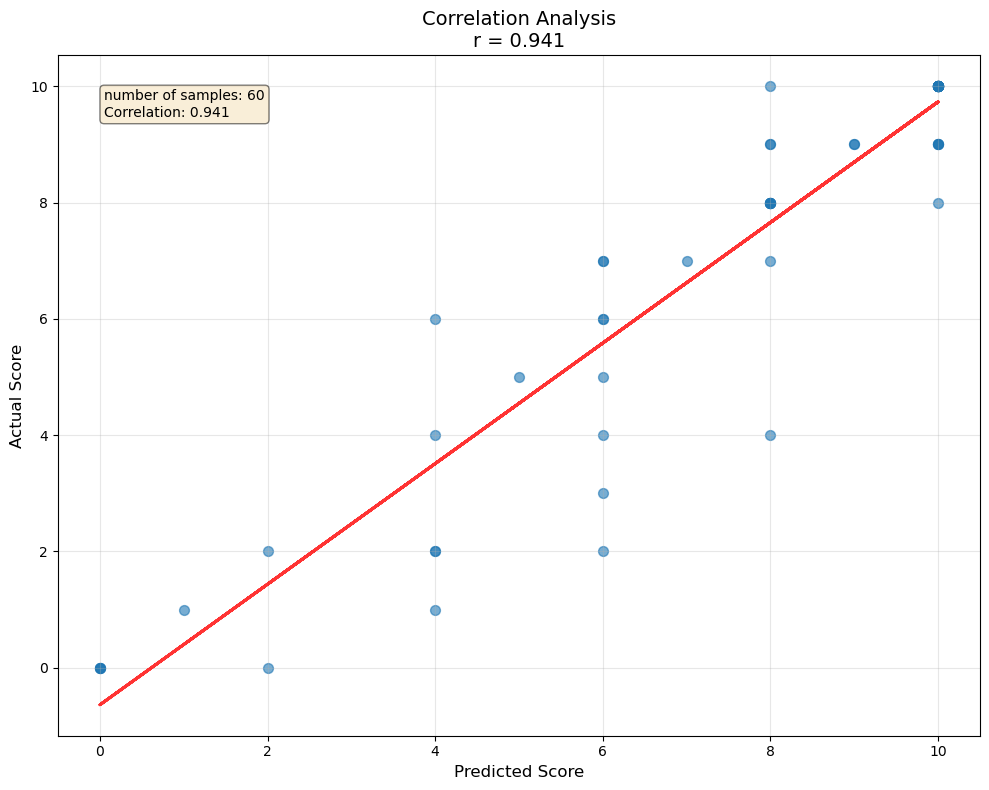

'/Users/rang/Documents/guess_end_result_correlation.png'

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

excel_path = "/Users/rang/Documents/guess_end_result.xlsx"

preds = df['예측 총점'].astype(float).to_numpy()
labels = df['실제 총점'].astype(float).to_numpy()

# 상관계수 계산
from scipy.stats import pearsonr
correlation, p_value = pearsonr(preds, labels)

# 그래프 저장 경로
graph_path = excel_path.replace('.xlsx', '_correlation.png')

def create_correlation_plot(preds, labels, correlation, title, output_path):
    """상관계수 산점도 그래프 생성"""
    plt.figure(figsize=(10, 8))
    
    # 산점도 그리기
    plt.scatter(preds, labels, alpha=0.6, s=50)
    
    # 회귀선 그리기
    z = np.polyfit(preds, labels, 1)
    p = np.poly1d(z)
    plt.plot(preds, p(preds), "r--", alpha=0.8, linewidth=2)
    
    # 그래프 설정
    plt.xlabel('Predicted Score', fontsize=12)
    plt.ylabel('Actual Score', fontsize=12)
    plt.title(f'{title}\nr = {correlation:.3f}', fontsize=14)
    
    # 통계 정보 텍스트 추가
    plt.text(0.05, 0.95, f'number of samples: {len(preds)}\nCorrelation: {correlation:.3f}', 
             transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.5),
             verticalalignment='top', fontsize=10)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # 그래프 저장
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ 상관계수 그래프 저장: {output_path}")
    
    # 그래프 표시
    plt.show()
    
    return output_path

# 4) 플롯 생성/저장
create_correlation_plot(
    preds=preds,   # 예측을 x로
    labels=labels,   # 정답을 y로
    correlation=correlation,
    title="Correlation Analysis",
    output_path=graph_path
)